# 1.0 Libraries & Set up

## In this section we import necessary libraries and apply plotting settings to the entire notebook

In [1]:
import os
os.chdir('../') # insures use of models folder as python module 
# Any figures saved or data pickled in the current working 
# directly will be saved up one folder from here.
import pybamm
import models
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] =  18.0
plt.rcParams['text.usetex'] = True

# 1.1 Single Layer Cell held at 30 degrees C

## 1.1.1 Initial conditions and basic parameters

### Parameter values and initial values as discussed in Cornish & Marinescu (2021) regarding equations (8), (9a), and (9b).

In [2]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T = 298
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# New exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star = 1e-6

# dissolution rate
kp = 5000

# Initial value of Precipitated sulfur at start of charge
Sp_initial_cha = .43

# Initial value of S1 anion at start of charge
S1_initial_cha = 1e-3

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T))*(V_initial_cha - (2*R*T/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha = S2_func(S1_initial_cha)

# Initial charge value of S2
S4_initial_cha = S4_func(S2_initial_cha)

# Initial charge value of S2
S8_initial_cha = S8_func(S4_initial_cha)

# Initial high plateau potential 
EH = EH0 + (R*T)*np.log(f_h*(S8_initial_cha**(1/4))/(S4_initial_cha**(1/2)))/(F)

# Initial high plateau over-potential
eta_H = V_initial_cha - EH

# Initial high plateau current
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))

# Initial middle plateau potential
EM = EM0 + (R*T)*np.log(f_m*(S4_initial_cha**(1/2))/S2_initial_cha)/(F)

# Initial middle plateau over-potentia
eta_M = V_initial_cha - EM

# Initial middle plateau current
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))

# Initial low plateau potential
EL = EL0 + (R*T/F)*np.log(f_l*(S2_initial_cha**(1/2))/S1_initial_cha)

# Initial low plateau over-potentia
eta_L = V_initial_cha - EL

# Initial low plateau current
iL = -2*il0*ar*np.sinh(F*eta_L/(2*R*T))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H))
print('The initial charge value of the high plateau current is {} A'.format(iH))
print('The initial charge value of the middle plateau potential is {} V'.format(EM))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M))
print('The initial charge value of the middle plateau current is {} A'.format(iM))
print('The initial charge value of the low plateau potential is {} V'.format(EL))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L))
print('The initial charge value of the low plateau current is {} A'.format(iL))

The initial charge value of precipitated sulfur is 0.43 g
The initial charge value of S1 anion is 0.001 g
The initial charge value of S2 anion is 0.013113145894720814 g
The initial charge value of S4 anion is 6.38122975361841e-18 g
The initial charge value of S8 anion is 4.5372721447883005e-64 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.9998871215691447 V
The initial charge value of the low plateau over-potential is 0.00011287843085527882 V
The initial charge value of the low plateau current is -0.021100000000008695 A


## 1.1.2 Fit 30 Degree Cell Charge Voltage 

In [3]:
# Instantiate the model
model_30 = models.Cornish2021()

# Obtain model parameter dictionary
param_30 = model_30.default_parameter_values

# Update the parameters for charge
param_30.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        }
)

# Instantiate simulation object 
sim_30_cha1 = pybamm.Simulation(
    model_30,
    parameter_values = param_30,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 1.2*int(3600/0.1)

# Simulate the model 
sim_30_cha1.solve([0,time_in_seconds]);


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

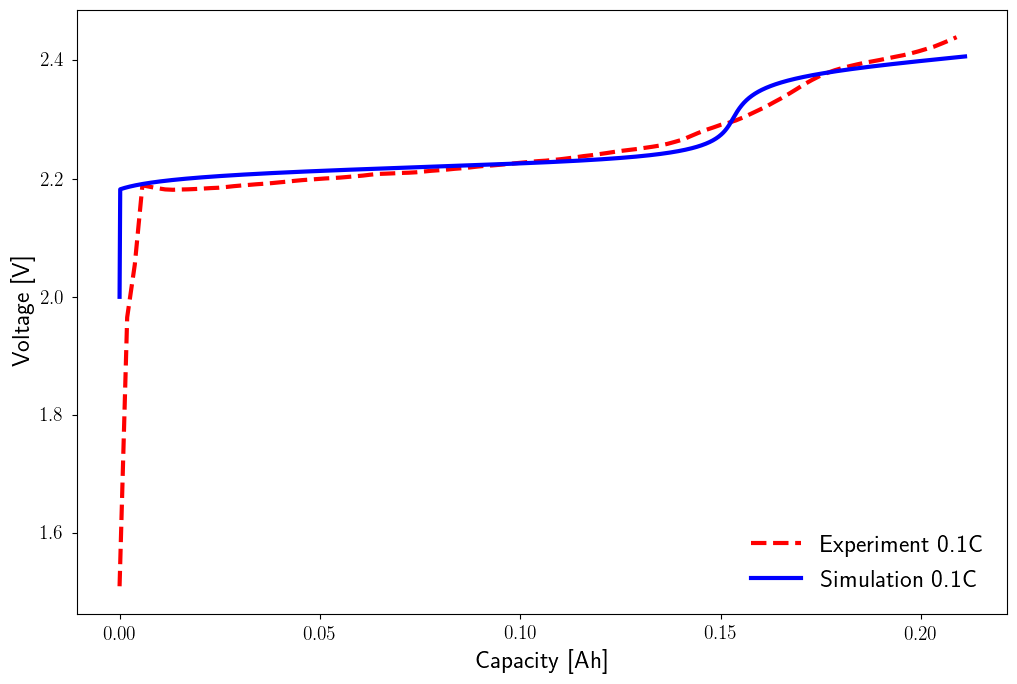

In [4]:
index = len(sim_30_cha1.solution.t[sim_30_cha1.solution.t < 36001])

capacity = abs(I)*sim_30_cha1.solution.t[:index]/3600
voltage = sim_30_cha1.solution['Terminal voltage [V]'].entries[:index]

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'], linestyle='--')

plt.plot(capacity, voltage)
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.3 Fit the Charge Resistance

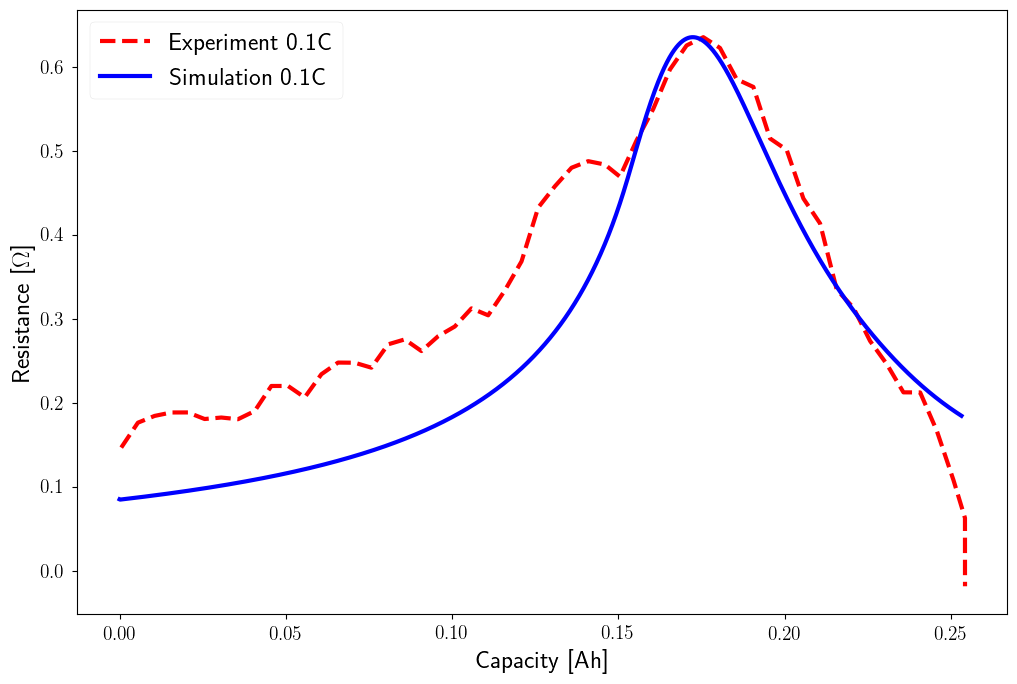

In [5]:
capacity = .0211*sim_30_cha1.solution.t/3600
S4 = sim_30_cha1.solution['S4 [g]'].entries
S2 = sim_30_cha1.solution['S2 [g]'].entries
S1 = sim_30_cha1.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
plt.plot(res_charge_data['30'][0],res_charge_data['30'][1],linestyle='--')

beta1 = max(Li)*1.15
R = 1/(beta1-Li)
alpha1 = max(res_charge_data['30'][1])/max(R)
R *= alpha1

plt.plot(capacity,R)


plt.legend(['Experiment 0.1C', 'Simulation 0.1C'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');

## 1.1.4 Fit The Discharge Voltage Curve

In [6]:
loc = index
S1_initial = sim_30_cha1.solution['S [g]'].entries[loc]
S2_initial = sim_30_cha1.solution['S2 [g]'].entries[loc]
S4_initial = sim_30_cha1.solution['S4 [g]'].entries[loc]
S8_initial = sim_30_cha1.solution['S8 [g]'].entries[loc]
Sp_initial = sim_30_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial = sim_30_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S1_initial)
print(Sp_initial)
print(V_initial)

0.0009128054311124569
0.15946155364017017
0.27618344094501446
6.073008769350597e-10
0.007555345271110076
2.4066183465793545


In [7]:
model_30_dis1 = models.Cornish2021()

param_30_dis1 = model_30_dis1.default_parameter_values
param_30_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 60,
        }
)


sim_30_dis1 = pybamm.Simulation(
    model_30_dis1,
    parameter_values = param_30_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time = 0
time_in_seconds = 18400#3600*6
sim_30_dis1.step(2000)
time = 2000
while time < time_in_seconds:
    try:
        sim_30_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_30_dis1.step(.1)
            time += .1
        except:
            try:
                sim.step(0.01)
                time += 0.01
            except:
                break
                
while time < time_in_seconds:
    try:
        sim_30_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_30_dis1.step(.1)
            time += .1
        except:
            try:
                sim_30_dis1.step(0.0001)
                time += 0.0001
            except:
                break
print('\n\n\n\n\n\n\n\n\n done')

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2864.35 and h

At t = 2870.78 and h = 4.53404e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2882.2 and h 










 done


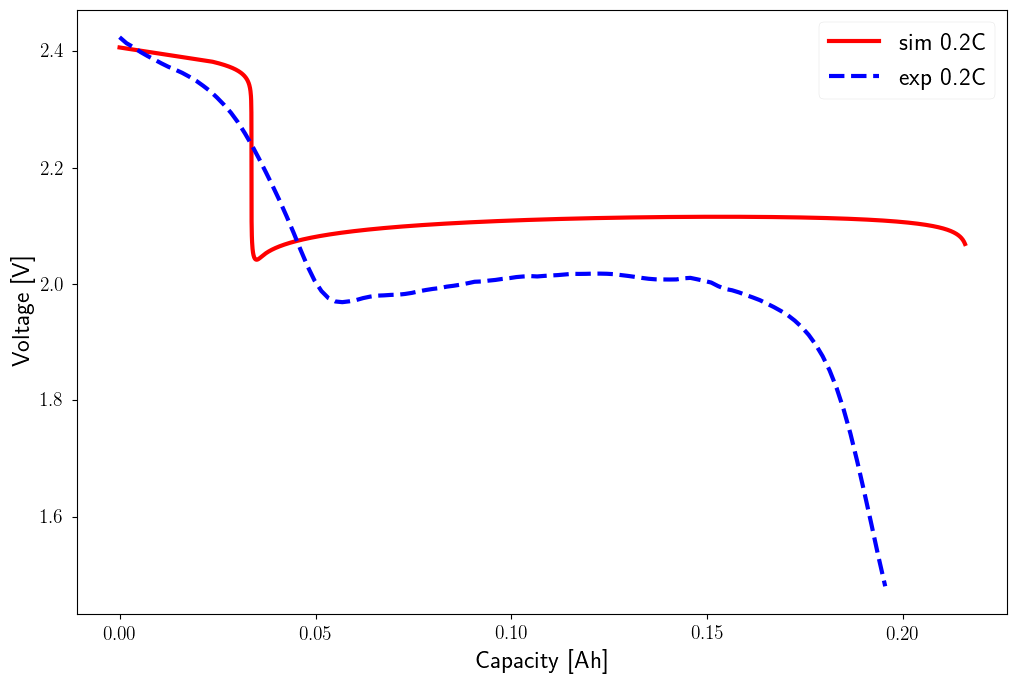

In [8]:
plt.plot(sim_30_dis1.solution.t*0.0422/3600, sim_30_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], linestyle='--')

plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

# 1.2 The 40 degree Cell

In [9]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T = 298 + 10
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# New exchange current constants
ih0 = .5
im0 = .5
il0 = .5

# Saturation mass constant
S_star = 1e-7

# dissolution rate
kp = 15000

# Initial value of Precipitated sulfur at start of charge
Sp_initial_cha = .43

# Initial value of S1 anion at start of charge
S1_initial_cha = 1e-3

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T))*(V_initial_cha - (2*R*T/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha = S2_func(S1_initial_cha)

# Initial charge value of S2
S4_initial_cha = S4_func(S2_initial_cha)

# Initial charge value of S2
S8_initial_cha = S8_func(S4_initial_cha)

# Initial high plateau potential 
EH = EH0 + (R*T)*np.log(f_h*(S8_initial_cha**(1/4))/(S4_initial_cha**(1/2)))/(F)

# Initial high plateau over-potential
eta_H = V_initial_cha - EH

# Initial high plateau current
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))

# Initial middle plateau potential
EM = EM0 + (R*T)*np.log(f_m*(S4_initial_cha**(1/2))/S2_initial_cha)/(F)

# Initial middle plateau over-potentia
eta_M = V_initial_cha - EM

# Initial middle plateau current
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))

# Initial low plateau potential
EL = EL0 + (R*T/F)*np.log(f_l*(S2_initial_cha**(1/2))/S1_initial_cha)

# Initial low plateau over-potentia
eta_L = V_initial_cha - EL

# Initial low plateau current
iL = -2*il0*ar*np.sinh(F*eta_L/(2*R*T))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H))
print('The initial charge value of the high plateau current is {} A'.format(iH))
print('The initial charge value of the middle plateau potential is {} V'.format(EM))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M))
print('The initial charge value of the middle plateau current is {} A'.format(iM))
print('The initial charge value of the low plateau potential is {} V'.format(EL))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L))
print('The initial charge value of the low plateau current is {} A'.format(iL))

The initial charge value of precipitated sulfur is 0.43 g
The initial charge value of S1 anion is 0.001 g
The initial charge value of S2 anion is 0.009408564446683457 g
The initial charge value of S4 anion is 9.26428320138686e-18 g
The initial charge value of S8 anion is 8.415655110738621e-63 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.9988334299963695 V
The initial charge value of the low plateau over-potential is 0.0011665700036305182 V
The initial charge value of the low plateau current is -0.021100000000000393 A


In [10]:
# Instantiate the model
model_40 = models.Cornish2021()

# Obtain model parameter dictionary
param_40 = model_40.default_parameter_values

# Update the parameters for charge
param_40.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during charge [s-1]': 0.001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        }
)

# Instantiate simulation object 
sim_40_cha1 = pybamm.Simulation(
    model_40,
    parameter_values = param_40,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 1.2*int(3600/0.1)

# Simulate the model 
sim_40_cha1.solve([0,time_in_seconds]);

At t = 0 and h = 3.65733e-12, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casad

Traceback (most recent call last):
  File "/Users/Work/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/0m/hp806rv14qz74rjlmvs9nzbm0000gp/T/ipykernel_31460/1972746457.py", line 50, in <module>
    sim_40_cha1.solve([0,time_in_seconds]);
  File "/Users/Work/PyBaMM/pybamm/simulation.py", line 706, in solve
    self._solution = solver.solve(self.built_model, t_eval, **kwargs)
  File "/Users/Work/PyBaMM/pybamm/solvers/base_solver.py", line 732, in solve
    new_solution = self._integrate(
  File "/Users/Work/PyBaMM/pybamm/solvers/casadi_solver.py", line 219, in _integrate
    raise pybamm.SolverError(
pybamm.expression_tree.exceptions.SolverError: Maximum number of decreased steps occurred at t=0.0. Try solving the model up to this time only or reducing dt_max (currently, dt_max=0.013449928977272829).

During handling of the above exception, another exception occurred:

Trace

TypeError: object of type 'NoneType' has no len()

# 1.3 The 40 degree Cell

In [ ]:
# Instantiate the model
model_20 = models.Cornish2021()

# Obtain model parameter dictionary
param_20 = model_20.default_parameter_values

# Update the parameters for charge
param_20.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star,
        'Shuttle rate coefficient during charge [s-1]': 0.0001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        }
)

# Instantiate simulation object 
sim_20_cha1 = pybamm.Simulation(
    model_20,
    parameter_values = param_20,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 1.2*int(3600/0.1)

# Simulate the model 
sim_20_cha1.solve([0,time_in_seconds]);

In [ ]:
# We ca

## The above initial state for charge is unrealistic, but mathematically tractible. 

## The end of charge state should now be more realistic.

## Now we can cycle the cell with similar conditions to the experiment.

In [ ]:
# Discharge initial condition 
V_initial_dis = sim_cha1.solution['Terminal voltage [V]'].entries[-1]
S8_initial_dis = sim_cha1.solution['S8 [g]'].entries[-1]
S4_initial_dis = sim_cha1.solution['S4 [g]'].entries[-1]
S2_initial_dis = sim_cha1.solution['S2 [g]'].entries[-1]
S1_initial_dis = sim_cha1.solution['S [g]'].entries[-1]
Sp_initial_dis = sim_cha1.solution['Precipitated Sulfur [g]'].entries[-1]

In [ ]:
# Reinstantiate the model
model = models.Cornish2021()

# Obtain and update parameter values
param = model.default_parameter_values
param.update(
    {
        "Current function [A]": -2*I,
        "Initial Condition for Terminal Voltage [V]": V_initial_dis,
        "Initial Condition for S8 ion [g]" : S8_initial_dis,
        "Initial Condition for S4 ion [g]" : S4_initial_dis,
        "Initial Condition for S2 ion [g]" : S2_initial_dis,
        "Initial Condition for S ion [g]" : S1_initial_dis,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_dis,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        'Shuttle rate coefficient during charge [s-1]': .001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': 100
        }
)



# Instantiate simulation object 
sim_dis1 = pybamm.Simulation(
    model,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

time_in_seconds = 3600*6
sim_dis1.step(2000)
time = 2000
while time < time_in_seconds:
    try:
        sim_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_dis1.step(.1)
            time += .1
        except:
            try:
                sim.step(0.01)
                time += 0.01
            except:
                break
                
while time < time_in_seconds:
    try:
        sim_dis1.step(5)
        time+= 5
    except:
        try: 
            sim_dis1.step(.1)
            time += .1
        except:
            try:
                sim_dis1.step(0.0001)
                time += 0.0001
            except:
                break
print('\n\n\n\n\n\n\n\n\n done')

In [ ]:
capacity = abs(2*I)*sim_dis1.solution.t/3600
voltage = sim_dis1.solution['Terminal voltage [V]'].entries

plt.plot(capacity, voltage)

In [ ]:
# New charge initial condition 
loc = -10
S8_initial_cha2 = sim_dis1.solution['S8 [g]'].entries[loc]
S4_initial_cha2 = sim_dis1.solution['S4 [g]'].entries[loc]
S2_initial_cha2 = sim_dis1.solution['S2 [g]'].entries[loc]
S1_initial_cha2 = sim_dis1.solution['S [g]'].entries[loc]
Sp_initial_cha2 = sim_dis1.solution['Precipitated Sulfur [g]'].entries[loc]

In [ ]:
print(S8_initial_cha)

In [ ]:
# Reinstantiate the model
model = models.Cornish2021()

# Obtain and update parameter values
param = model.default_parameter_values
param.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": 1.8,
        "Initial Condition for S8 ion [g]" : S8_initial_cha2,
        "Initial Condition for S4 ion [g]" : S4_initial_cha2,
        "Initial Condition for S2 ion [g]" : S2_initial_cha2,
        "Initial Condition for S ion [g]" : S1_initial_cha2,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha2,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        'Shuttle rate coefficient during charge [s-1]': .001,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        }
)



# Instantiate simulation object 
sim_cha2 = pybamm.Simulation(
    model,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

time_in_seconds = 3600*10
sim_cha2.solve([0,time_in_seconds])
'''
sim_cha2.step(2000)
time = 2000
while time < time_in_seconds:
    try:
        sim_cha2.step(5)
        time+= 5
    except:
        try: 
            sim_cha2.step(.1)
            time += .1
        except:
            try:
                sim_cha2.step(0.01)
                time += 0.01
            except:
                break
print('\n\n\n\n\n\n\n\n\n done')
'''

In [ ]:
charge = abs(I)*sim_cha2.solution.t/3600
voltage = sim_cha2.solution['Terminal voltage [V]'].entries

plt.plot(charge, voltage)